# Imports and load dataset

In [40]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.stats import t
from scipy.stats import gumbel_r
from scipy.stats import kendalltau

from scipy.optimize import minimize_scalar 

from statsmodels.distributions.copula.api import StudentTCopula, ClaytonCopula

from sklearn.mixture import GaussianMixture
from copulas.multivariate import GaussianMultivariate

import matplotlib.pyplot as plt

from copulas.bivariate import Clayton

In [2]:
df = pd.read_excel('573379_604455.xlsx')
df = df[['Stock1','Stock2']]
df.head()

,Stock1,Stock2
0,2.67,2.91
1,6.81,4.16
2,-2.32,-1.38
3,7.36,1.24
4,-5.16,-4.17


# Useful functions

In [3]:
def round_sig(x, sig=4):
    return round(x, sig-int(np.floor(np.log10(abs(x))))-1)

# 1 Variance–covariance approach based on the two series


In [4]:
# calculate the mean, variance, and covariance of the two stocks and print them out in format of a table
mean_loss_return_stock1 = df['Stock1'].mean()
mean_loss_return_stock2 = df['Stock2'].mean()
std_loss_return_stock1 = df['Stock1'].std()
std_loss_return_stock2 = df['Stock2'].std()
var_loss_return_stock1 = df['Stock1'].var()
var_loss_return_stock2 = df['Stock2'].var()
covariance = df['Stock1'].cov(df['Stock2'])
correlation = df['Stock1'].corr(df['Stock2'])

print('Mean Loss Return of Stock 1: ', round_sig(mean_loss_return_stock1))
print('Mean Loss Return of Stock 2: ', round_sig(mean_loss_return_stock2))

print('Standard Deviation of Loss Return of Stock 1: ', round_sig(std_loss_return_stock1))
print('Standard Deviation of Loss Return of Stock 2: ', round_sig(std_loss_return_stock2))

print('Variance of Loss Return of Stock 1: ', round_sig(var_loss_return_stock1))
print('Variance of Loss Return of Stock 2: ', round_sig(var_loss_return_stock2))

print('Covariance of Loss Return of Stock 1 and Stock 2: ', round_sig(covariance))
print('Correlation of Loss Return of Stock 1 and Stock 2: ', round_sig(correlation))


Mean Loss Return of Stock 1:  -0.03283
Mean Loss Return of Stock 2:  0.03041
Standard Deviation of Loss Return of Stock 1:  5.157
Standard Deviation of Loss Return of Stock 2:  4.384
Variance of Loss Return of Stock 1:  26.59
Variance of Loss Return of Stock 2:  19.22
Covariance of Loss Return of Stock 1 and Stock 2:  18.57
Correlation of Loss Return of Stock 1 and Stock 2:  0.8215


In [5]:
weight_stock1 = 0.5
weight_stock2 = 0.5

portfolio_variance = (var_loss_return_stock1 * weight_stock1 ** 2) + (var_loss_return_stock2 * weight_stock2 ** 2) + (2 * weight_stock1 * weight_stock2 * covariance)

print('Portfolio Variance: ', round_sig(portfolio_variance))

portfolio_std = np.sqrt(portfolio_variance)
portfolio_mean = (mean_loss_return_stock1 * weight_stock1) + (mean_loss_return_stock2 * weight_stock2)

print('Portfolio Standard Deviation: ', round_sig(portfolio_std))
print('Portfolio Mean: ', round_sig(portfolio_mean))

Portfolio Variance:  20.74
Portfolio Standard Deviation:  4.554
Portfolio Mean:  -0.001213


In [6]:
# Calculate the inverse of the normal cumulative distribution function for a probability of 0.99
norminv = norm.ppf(0.99)
# Calculate the one-day VaR(99%) for the portfolio loss returns
var_99_method_1 = portfolio_mean + (norminv * portfolio_std)

#Note: 
# Expected profit: portfolio_mean + (norminv * portfolio_std)
# Expected loss: -portfolio_mean - (norminv * portfolio_std)

print('VaR(99%) for the portfolio loss returns: ', round_sig(var_99_method_1))



VaR(99%) for the portfolio loss returns:  10.59


# 2 Historical Simulation based on the portfolio loss returns

In [7]:
# Calculate the portfolio loss returns for each day
df['Portfolio_loss_return'] = (weight_stock1 * df['Stock1']) + (weight_stock2 * df['Stock2'])

# Sort the portfolio loss returns in ascending order
df_sorted = df.sort_values('Portfolio_loss_return', ascending= False)

# Reset index
df_sorted = df_sorted.reset_index(drop=True)

# Calculate the one-day VaR(99%) as the 100th percentile of the sorted portfolio loss returns
var_99_method_2 = df_sorted.iloc[int(0.01 * len(df_sorted))-1]['Portfolio_loss_return']

print('One-day VaR(99%): ', round_sig(var_99_method_2,))

One-day VaR(99%):  12.21


# 3 A normal mixture model mixing two normal distributions

### Hint: Conduct a JB test to check the normality of the portfolio loss return.

In [8]:
# Check the normality of the portfolio loss returns using the JB test
statistic, p_value = jarque_bera(df['Portfolio_loss_return'])

print('JB test statistic: ', round_sig(statistic))
print('JB test p-value: ', round_sig(p_value))

JB test statistic:  465.1
JB test p-value:  1.0069999999999993e-101


In [9]:
if p_value > 0.05:
    # The JB test indicates that the portfolio loss returns are not normally distributed
    print('The portfolio loss returns are not normally distributed.')
else:
    # The JB test indicates that the portfolio loss returns are normally distributed
    # Fit a normal mixture model to the portfolio loss returns
    gmm = GaussianMixture(n_components=2)
    gmm.fit(df['Portfolio_loss_return'].values.reshape(-1, 1))

    # Get the means, standard deviations, and probabilities of the normal distributions
    means = gmm.means_
    stds = np.sqrt(gmm.covariances_).squeeze()
    probs = gmm.weights_

    # Print the results
    print("Mean normal 1: ", round_sig(means[0][0]))
    print("Mean normal 2: ", round_sig(means[1][0]))
    print("Std normal 1: ", round_sig(stds[0]))
    print("Std normal 2: ", round_sig(stds[1]))
    print("Prob normal 1: ", round_sig(probs[0]))
    print("Prob normal 2: ", round_sig(probs[1]))


Mean normal 1:  1.488
Mean normal 2:  -1.591
Std normal 1:  4.205
Std normal 2:  4.368
Prob normal 1:  0.5163
Prob normal 2:  0.4837


In [10]:
# Generate a large number of samples from the normal mixture model
num_samples = 100000000
samples = gmm.sample(n_samples=num_samples)[0]

samples = samples.reshape(1,-1)[0]
samples = np.sort(samples, )
samples = samples[::-1]

var_method_3 = samples[int(0.01 * len(samples))-1]
print('Var 99%: ' , var_method_3)


Var 99%:  10.441025966051335


# 6 Copula and upper tail dependence

In [28]:
# Use Maximum Likelihood Estimation to fit the marginal distributions of two variables to Student's t-distributions
marginal_distribution1_params = t.fit(df[df.columns[0]])
marginal_distribution2_params = t.fit(df[df.columns[1]])

print('The parameters for the first marginal distribution are:', marginal_distribution1_params)
print('The parameters for the second marginal distribution are:', marginal_distribution2_params)
print()

dof_marginal_distribution1 = marginal_distribution1_params[0]
dof_marginal_distribution2 = marginal_distribution2_params[0]

mean_marginal_distribution1 = marginal_distribution1_params[1]
mean_marginal_distribution2 = marginal_distribution2_params[1]

sigma_marginal_distribution1 = marginal_distribution1_params[2]
sigma_marginal_distribution2 = marginal_distribution2_params[2]

print('DOF 1:', dof_marginal_distribution1)
print('DOF 2:', dof_marginal_distribution2)
print('Mean 1:', mean_marginal_distribution1)
print('Mean 2:', mean_marginal_distribution2)
print('Sigma 1:', sigma_marginal_distribution1)
print('Sigma 2:', sigma_marginal_distribution2)
print()

# Calculate the Kendall Tau and Clayton copula theta

kendalltau_value = kendalltau(df[df.columns[0]], df[df.columns[1]])
#Clayton copula param: (tau = theta / (theta + 2)) => theta = -2*tau / (tau-1)
clayton_theta = -2*kendalltau_value[0] / (kendalltau_value[0]-1)

print('Kendall Tau: ', kendalltau_value[0])
print('Clayton Copula Theta: ', clayton_theta)

The parameters for the first marginal distribution are: (5.345019682571221, 0.002304010179161553, 4.097563258507986)
The parameters for the second marginal distribution are: (5.550778854900869, 0.05437234346310828, 3.5066114939509454)

DOF 1: 5.345019682571221
DOF 2: 5.550778854900869
Mean 1: 0.002304010179161553
Mean 2: 0.05437234346310828
Sigma 1: 4.097563258507986
Sigma 2: 3.5066114939509454

Kendall Tau:  0.6194317626607205
Clayton Copula Theta:  3.255299322883283


In [36]:
def simulationM6(dof1, dof2, mean1, mean2, sigma1, sigma2, theta, n_samples = 100000, ):
    #MC simulation of the copula
    clayton_copula = ClaytonCopula(theta)
    n = n_samples
    clayton_copula_samples = clayton_copula.rvs(nobs=n)

    # Simulate the returns from the copula
    returns = np.zeros((n, 2))
    returns[:, 0] = t.ppf((1-clayton_copula_samples[:, 0]), dof1, loc=mean1, scale=sigma1)
    returns[:, 1] = t.ppf((1-clayton_copula_samples[:, 1]), dof2, loc=mean2, scale=sigma2)
    losses = (returns[:, 0] + returns[:, 1]) / 2

    return losses

In [39]:
# Coefficient of the tail dependence : 2^(-1/theta)
tail_dep_coeff = 2**(-1/clayton_theta)
print(tail_dep_coeff, 'lower_tail_coeff (is upper tail in reverse clayton)')

#MC simulation of the copula
simulated_losses = simulationM6(dof_marginal_distribution1, dof_marginal_distribution2 ,mean_marginal_distribution1, mean_marginal_distribution2, sigma_marginal_distribution1, sigma_marginal_distribution2, clayton_theta)

# 99% VaR
VaR = np.percentile(simulated_losses, 99)
print('The 99% VaR is:', VaR)

0.8082136298059142 lower_tail_coeff (is upper tail in reverse clayton)
The 99% VaR is: 12.238165585519399


In [54]:
def upper_tail_coeff(data, threshold, num_rows):
    sorted_col1 = np.sort(data[:, 0], axis=0)
    sorted_col2 = np.sort(data[:, 1], axis=0)
    upper_tail_count = 0
    for i in range(num_rows):
        if data[i, 0] > sorted_col1[num_rows - 1 - threshold] and data[i, 1] > sorted_col2[num_rows - 1 - threshold]:
            upper_tail_count += 1

    upper_tail_count /= threshold
    return upper_tail_count


In [58]:
data = df.iloc[:,0:2].values
lambda_array = np.zeros((1999,1))

#Loop over the different values of k and calculate the empirical upper tail dependence coefficient
for i in range(len(lambda_array) - 1):
    lambda_array[i] = upper_tail_coeff(data,i+1, len(data))


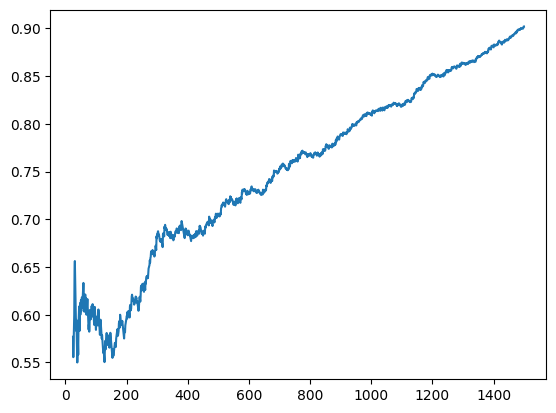

In [61]:
t_start = 25
t_end = 1500

x = range(t_start,t_end)
y = lambda_array[t_start:t_end]

plt.plot(x,y)
plt.show()